In [25]:
# !pip install torch
# !pip install pandas
# !pip install numpy
# !pip install transformers
# !pip install openpyxl
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn

In [1]:
import os, warnings, torch
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
warnings.filterwarnings('ignore')

data_dir = os.path.join(os.getcwd(), "Dataset")
output_dir = os.path.join(os.getcwd(), "models", "roberta-base_v2")

## Read in dataset

In [2]:
processed_df = pd.read_csv(os.path.join(data_dir,"emotions_processed_df.csv"))
processed_df.sample(5)

,sentiment,content
31903,worry,reesnicole twitter reunion would awesome meet ...
44191,fear,wish know really feel aside read nervous twitch
10027,worry,bad day
54181,anger,wish could bottle squeal delight take whenever...
37636,relief,fear creep already dismiss let thing right coz...


In [3]:
processed_df = processed_df.rename(columns={"sentiment": "labels", "content": "text"})
processed_df.sample(5)

,labels,text
30348,neutral,good morning six hundred and fifteen plan day ...
16126,worry,jesamine appropriate tweet everything ok last ...
28361,worry,speak new tweeples get acquaint never speak
26079,happiness,evanmcbroom sure mayor brainard thrill hear fan
17131,empty,start get annoy socialscope need update


In [4]:
processed_df["labels"].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'love',
       'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger', 'fear',
       'happy'], dtype=object)

In [5]:
processed_df.isnull().sum()

labels     0
text      15
dtype: int64

In [6]:
processed_df = processed_df.dropna()
processed_df.isnull().sum()

labels    0
text      0
dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(processed_df['labels'])
X = processed_df.iloc[:,1:2]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [8]:
le = LabelEncoder()
le.fit(processed_df['labels'])
le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(le_name_mapping)

class_name = []

#print both key and value from mapping 
for key, value in le_name_mapping.items():
    print(key, value)
    class_name.append(value)

{0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm', 4: 'fear', 5: 'fun', 6: 'happiness', 7: 'happy', 8: 'hate', 9: 'love', 10: 'neutral', 11: 'relief', 12: 'sadness', 13: 'worry'}
0 anger
1 boredom
2 empty
3 enthusiasm
4 fear
5 fun
6 happiness
7 happy
8 hate
9 love
10 neutral
11 relief
12 sadness
13 worry


In [9]:
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [10]:
#padding and truncation of data
inputs = tokenizer(X_train['text'].tolist(), padding="max_length", truncation=True)

In [11]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = EmotionDataset(inputs, y_train)

## Model Building

In [12]:
num_labels = len(processed_df["labels"].unique())
num_labels

14

In [13]:
from transformers import RobertaForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [15]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [16]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [17]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=5000,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # how often to log
    save_steps = 5000,
    save_total_limit = 2       
)
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

***** Running training *****
  Num examples = 46702
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8757
  Number of trainable parameters = 124656398


Step,Training Loss
100,2.739200
200,2.572000
300,2.227200
400,2.056600
500,1.921300
600,1.850200
700,1.774200
800,1.689400
900,1.635300
1000,1.658800


Saving model checkpoint to ./results/checkpoint-5000
Configuration saved in ./results/checkpoint-5000/config.json
Model weights saved in ./results/checkpoint-5000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-5000] due to args.save_total_limit
Deleting older checkpoint [results/checkpoint-10000] due to args.save_total_limit
Deleting older checkpoint [results/checkpoint-500] due to args.save_total_limit
Deleting older checkpoint [results/checkpoint-1000] due to args.save_total_limit
Deleting older checkpoint [results/checkpoint-1500] due to args.save_total_limit
Deleting older checkpoint [results/checkpoint-2000] due to args.save_total_limit
Deleting older checkpoint [results/checkpoint-2500] due to args.save_total_limit
Deleting older checkpoint [results/checkpoint-3000] due to args.save_total_limit
Deleting older checkpoint [results/checkpoint-3500] due to args.save_total_limit
Deleting older checkpoint [results/checkpoint-4000] due to args.save_total_limit
Deleting 

TrainOutput(global_step=8757, training_loss=1.3719615912320366, metrics={'train_runtime': 3250.8703, 'train_samples_per_second': 43.098, 'train_steps_per_second': 2.694, 'total_flos': 3.686740930544026e+16, 'train_loss': 1.3719615912320366, 'epoch': 3.0})

In [9]:
# Load a trained model and vocabulary that you have fine-tuned
model_class, tokenizer_class, pretrained_weights = (transformers.RobertaForSequenceClassification, transformers.RobertaTokenizer, 'roberta-base')

model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Copy the model to the GPU.
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [10]:
def to_check_result(test_encoding):
    input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
    attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
    with torch.no_grad():
        output = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
    y = np.argmax(output[0].to("cpu").numpy())
    return y

In [11]:
test_emotions = []
for i in X_test["text"]:
    test_encoding1 = tokenizer(i, padding=True, truncation=True)
    input_ids = torch.tensor(test_encoding1["input_ids"]).to(device)
    attention_mask = torch.tensor(test_encoding1["attention_mask"]).to(device)
    test_emotions.append(to_check_result(test_encoding1))

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

 Accuracy 0.586
 Precision 0.5687 
 Recall 0.586 
 F1 0.5719

Confusion Matrix:
 [[ 562    0    0    0    2    1    3    3    2    5   16    0   23   18]
 [   0    0    0    0    0    0    6    0    3    1    9    1    9   16]
 [   0    0    0    0    0    1   12    0    5    4   84    2   13   45]
 [   0    0    0    0    0    2   49    1    4   10   54    0   10   29]
 [  20    0    0    0  454    0    0    2    0    0    3    0    9    2]
 [   1    0    0    0    0   20  129    0    4   33  102    2   20   44]
 [   1    0    0    0    0   16  528   10    4  154  192   17   30  105]
 [   3    0    0    0    4    0    4 1383    0   15    2    0   10    2]
 [   2    0    0    0    0    0   11    0   95    3   32    3   41   83]
 [   2    0    0    0    2    3  188   97    5  619   87    4   53   52]
 [   2    0    0    0    2   18  235    6   28   61  889   12  104  343]
 [   0    0    0    0    0    1   98    4    6   19   83   18    8   78]
 [  20    0    0    0   23    6   63   15  

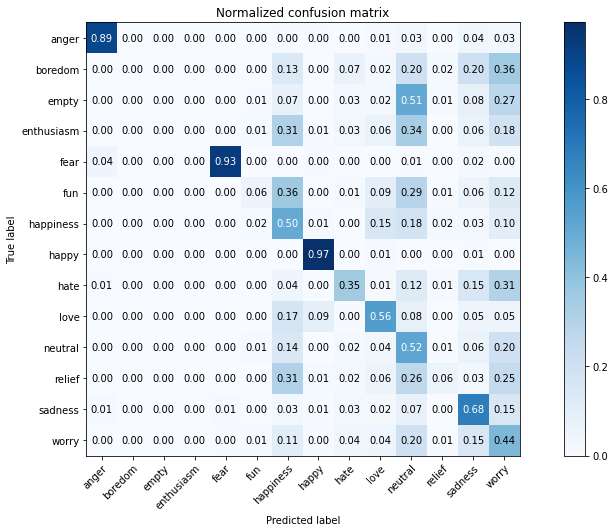

In [13]:
#checking the accuracy of the model
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
acc = round(accuracy_score(y_test, test_emotions),4)
pre = round(precision_score(y_test, test_emotions, average='weighted'),4)
rec = round(recall_score(y_test, test_emotions, average='weighted'),4)
f1 = round(f1_score(y_test, test_emotions, average='weighted'),4)

print(" Accuracy", acc)
print(" Precision",pre,"\n","Recall",rec,"\n","F1",f1)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, test_emotions))
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, test_emotions, classes=class_name, normalize=True, title='Normalized confusion matrix')
plt.show()

In [21]:
model_dir = 'roberta-base/'
output_dir = './model_save/'+model_dir

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Configuration saved in ./model_save/roberta-base/config.json


Saving model to ./model_save/roberta-base/


Model weights saved in ./model_save/roberta-base/pytorch_model.bin
tokenizer config file saved in ./model_save/roberta-base/tokenizer_config.json
Special tokens file saved in ./model_save/roberta-base/special_tokens_map.json


('./model_save/roberta-base/tokenizer_config.json',
 './model_save/roberta-base/special_tokens_map.json',
 './model_save/roberta-base/vocab.json',
 './model_save/roberta-base/merges.txt',
 './model_save/roberta-base/added_tokens.json')

In [53]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

# OLD

In [1]:
# Basic Imports
import os, warnings, openpyxl
import nltk
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

# Data preparation and text-preprocessing
import inflect, contractions, re, string, unicodedata, spacy
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import LancasterStemmer
# from nltk.stem import WordNetLemmatizerd

data_dir = os.path.join(os.getcwd(), "Dataset")

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [3]:
processed_df = pd.read_csv(os.path.join(data_dir,"processed_df.csv"))

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(processed_df['sentiment'])
X = processed_df.iloc[:,1:2]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(
    X.values.tolist(),
    y.tolist(), 
    test_size=0.2,
    random_state=7
)

In [29]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 14.0kB/s]
Downloading: 100%|██████████| 226k/226k [00:00<00:00, 251kB/s] 
Downloading: 100%|██████████| 455k/455k [00:01<00:00, 244kB/s]  
Downloading: 100%|██████████| 483/483 [00:00<00:00, 483kB/s]


In [31]:
X_train_list = []
for i in range(len(X_train)):
    X_train_list.append(str(X_train.iloc[i,0]))

In [33]:
X_test_list = []
for i in range(len(X_test)):
    X_test_list.append(str(X_test.iloc[i,0]))

In [35]:
train_encodings = tokenizer(X_train_list, truncation=True, padding=True)
val_encodings = tokenizer(X_test_list, truncation=True, padding=True)
#test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [43]:
import torch

class Cord19Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Cord19Dataset(train_encodings, y_train)
val_dataset = Cord19Dataset(val_encodings, y_test)

In [44]:
from transformers import BertForSequenceClassification
model_name = "google/bert_uncased_L-4_H-512_A-8"
model = BertForSequenceClassification.from_pretrained(model_name)

loading configuration file https://huggingface.co/google/bert_uncased_L-4_H-512_A-8/resolve/main/config.json from cache at C:\Users\ezeki/.cache\huggingface\transformers\022b9c245d52433fa189c30c2081afd09fccab0384cf9594137b37e197fcb40e.6234cde00b8dff3cfb33fd0abfefde49389adf8ebf426be832a3baaf03ea67c2
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

https://huggingface.co/google/bert_uncased_L-4_H-512_A-8/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to C:\Users\ez

In [45]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.    
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
c:\Users\ezeki\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 47112
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8835
















































































































{'loss': 0.5453, 'learning_rate': 5e-05, 'epoch': 0.17}








































































































































































                                        
                                                           

  0%|          | 0/8835 [12:09<?, ?it/s]          
Saving model checkpoint to ./results\checkpoint-1000
Configuration saved in ./results\checkpoint-1000\config.json
Model weights saved in ./results\checkpoint-1000\pytorch_model.bin


{'loss': 0.4331, 'learning_rate': 4.7000599880024e-05, 'epoch': 0.34}


Deleting older checkpoint [results\checkpoint-500] due to args.save_total_limit







































































































































































                                        
                                                           

  0%|          | 0/8835 [12:28<?, ?it/s]           
Saving model checkpoint to ./results\checkpoint-1500
Configuration saved in ./results\checkpoint-1500\config.json
Model weights saved in ./results\checkpoint-1500\pytorch_model.bin


{'loss': 0.3975, 'learning_rate': 4.4001199760047995e-05, 'epoch': 0.51}


Deleting older checkpoint [results\checkpoint-1000] due to args.save_total_limit







































































































































































                                        
                                                           

  0%|          | 0/8835 [12:48<?, ?it/s]           
Saving model checkpoint to ./results\checkpoint-2000
Configuration saved in ./results\checkpoint-2000\config.json
Model weights saved in ./results\checkpoint-2000\pytorch_model.bin


{'loss': 0.3942, 'learning_rate': 4.100179964007199e-05, 'epoch': 0.68}


Deleting older checkpoint [results\checkpoint-1500] due to args.save_total_limit






































































































































































                                        
                                                           

  0%|          | 0/8835 [13:08<?, ?it/s]           
Saving model checkpoint to ./results\checkpoint-2500
Configuration saved in ./results\checkpoint-2500\config.json
Model weights saved in ./results\checkpoint-2500\pytorch_model.bin


{'loss': 0.3783, 'learning_rate': 3.800239952009598e-05, 'epoch': 0.85}


Deleting older checkpoint [results\checkpoint-2000] due to args.save_total_limit





















































































































































***** Running Evaluation *****
  Num examples = 11779
  Batch size = 64
























































































































                                        
                                                           

                                             


  0%|          | 0/8835 [13:32<?, ?it/s]         







{'eval_loss': 0.35994166135787964, 'eval_runtime': 6.3556, 'eval_samples_per_second': 1853.32, 'eval_steps_per_second': 29.108, 'epoch': 1.0}


KeyboardInterrupt: 

In [ ]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [15]:
# Tokenize the training data
X_train_list = []
for i in range(len(X_train)):
    X_train_list.append(str(X_train.iloc[i,0]))
#X_train_list
train_encodings = tokenizer(X_train_list, truncation=True, padding=True)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.    
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

In [38]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\ezeki/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\ezeki/.cache\huggingface\transformers\9c169103d7e5a73936dd2b627e42851bec0831212

RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Int'

In [22]:
y_train_list = []
for i in range(len(y_train)):
    y_train_list.append(int(y_train[i]))

In [27]:
# Convert the labels to tensors
train_labels = torch.tensor(y_train_list)

In [28]:
print(type(train_labels))

<class 'torch.Tensor'>


In [18]:
# Define the optimizer and the loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

c:\Users\ezeki\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

AttributeError: 'list' object has no attribute 'size'